In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing all libraries. Add libraries here

In [ ]:
import os
import shutil
import zipfile
import requests
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline
os.chdir("/content/drive/MyDrive")
!pip install black[jupyter] --quiet

<ipython-input-2-aa1268f6ed7b>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
os.getcwd()
!black /content/drive/MyDrive/Colab\ Notebooks/sandbox.ipynb

All done! ✨ 🍰 ✨
1 file left unchanged.


In [ ]:
# delete three created folders if necessary
import shutil

# Set the destination folder
dst_folder = '/content/drive/MyDrive/Dataset2'

# delete 3 subfolders in the destination folder
sub_folders = ['Normal', 'pnemo', 'tb']
for sub_folder in sub_folders:
    dst_path = os.path.join(dst_folder, sub_folder)
    if os.path.exists(dst_path):
        shutil.rmtree(dst_path)
        print(f"{dst_path} and its contents deleted.")
    else:
        print(f"{dst_path} not found.")

/content/drive/MyDrive/Dataset2/Normal not found.
/content/drive/MyDrive/Dataset2/pnemo not found.
/content/drive/MyDrive/Dataset2/tb not found.


In [ ]:
# create second folder called Dataset2 for undersampling using 1094 images for each class
import os
import random
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed

# Set the source and destination folders
src_folder = '/content/drive/MyDrive/Dataset'
dst_folder = '/content/drive/MyDrive/Dataset2'
flag = True

# create the destination folder
if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
else:
    print(f"{dst_folder} already exist")
    flag = False

# create 3 subfolders in the destination folder if they do not exist
sub_folders = ['Normal', 'pnemo', 'tb']
for sub_folder in sub_folders:
    dst_path = os.path.join(dst_folder, sub_folder)
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)

def copy_file(src_file, dst_file):
    shutil.copy2(src_file, dst_file)

if flag:
# copy 1094 random files from the source folders to the destination folders
    with ThreadPoolExecutor() as executor:
        for sub_folder in sub_folders:
            src_path = os.path.join(src_folder, sub_folder)
            dst_path = os.path.join(dst_folder, sub_folder)
            files = os.listdir(src_path)
            selected_files = random.sample(files, 1094)
            for file in selected_files:
                src_file = os.path.join(src_path, file)
                dst_file = os.path.join(dst_path)
                executor.submit(copy_file, src_file, dst_file)


# Print the number of files in each subfolder
for sub_folder in sub_folders:
    dst_path = os.path.join(dst_folder, sub_folder)
    files = os.listdir(dst_path)
    print(f"Number of files in {dst_path}: {len(files)}")


/content/drive/MyDrive/Dataset2 already exists. Not copying files.
Number of files in /content/drive/MyDrive/Dataset2/Normal: 1094
Number of files in /content/drive/MyDrive/Dataset2/pnemo: 1094
Number of files in /content/drive/MyDrive/Dataset2/tb: 1094


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_width = 224
img_height = 224
train_validation_seed = 3

data_dir = "/content/drive/MyDrive/Dataset2"
class_names = ["Normal", "Pneumonia", "TB"]

## shuflling before splitting the dataset
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
     subset="training",
     seed=train_validation_seed,
     image_size=(img_height, img_width),
     batch_size=batch_size,
     shuffle=True)


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.3,
    subset = "validation",
    seed = train_validation_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    Shuffle=True)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 3)
val_ds = val_ds.skip((1*val_batches) // 3)

Found 3282 files belonging to 3 classes.
Using 2298 files for training.
Found 3282 files belonging to 3 classes.
Using 984 files for validation.
72


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'pnemo', 'tb']


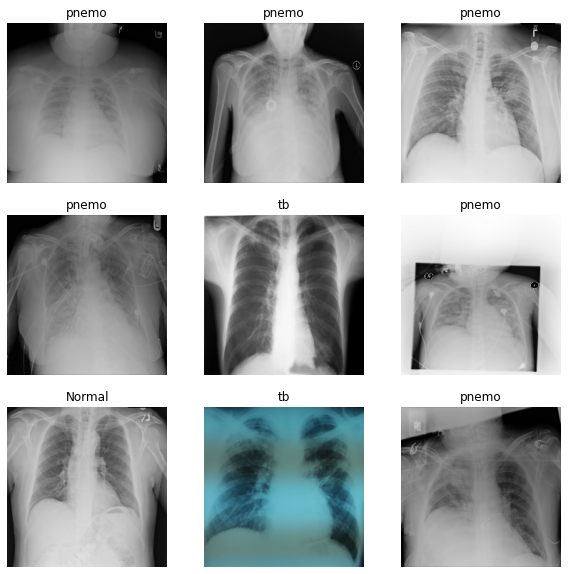

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Normalizing the dateset 
def process(image, label):
  image = tf.cast(image/255., tf.float32)
  return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
train_ds = train_ds.shuffle(2298, reshuffle_each_iteration=False)
val_ds = val_ds.shuffle(984,reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

72
21


In [ ]:
# using prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainables = False

In [ ]:
model = keras.Sequential()

model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
72/72 [==============================] - 222s 2s/step - loss: 0.5771 - accuracy: 0.7720 - val_loss: 1.5055 - val_accuracy: 0.4488
Epoch 2/20
72/72 [==============================] - 18s 253ms/step - loss: 0.3623 - accuracy: 0.8516 - val_loss: 3.0142 - val_accuracy: 0.6928
Epoch 3/20
72/72 [==============================] - 18s 257ms/step - loss: 0.3446 - accuracy: 0.8560 - val_loss: 0.4562 - val_accuracy: 0.8208
Epoch 4/20
72/72 [==============================] - 19s 262ms/step - loss: 0.3013 - accuracy: 0.8725 - val_loss: 0.5941 - val_accuracy: 0.8178
Epoch 5/20
72/72 [==============================] - 19s 265ms/step - loss: 0.2851 - accuracy: 0.8899 - val_loss: 0.9065 - val_accuracy: 0.7440
Epoch 6/20
72/72 [==============================] - 19s 269ms/step - loss: 0.1976 - accuracy: 0.9212 - val_loss: 0.6923 - val_accuracy: 0.7892
Epoch 7/20
72/72 [==============================] - 20s 272ms/step - loss: 0.1714 - accuracy: 0.9282 - val_loss: 0.6402 - val_accuracy: 0.7771
E

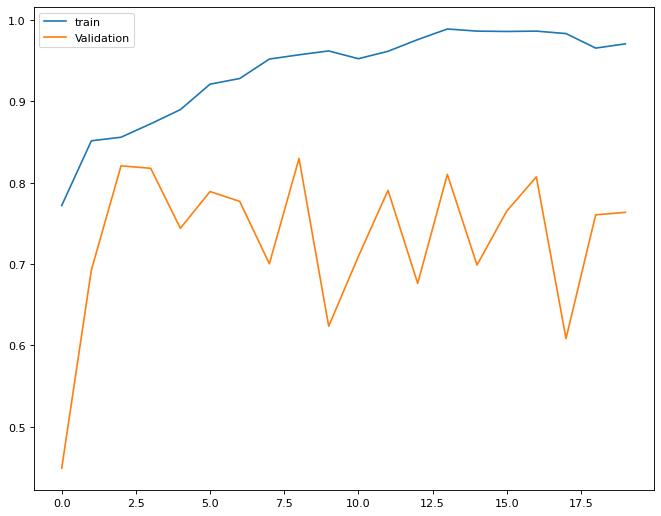

In [ ]:
# Plotting Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.show()

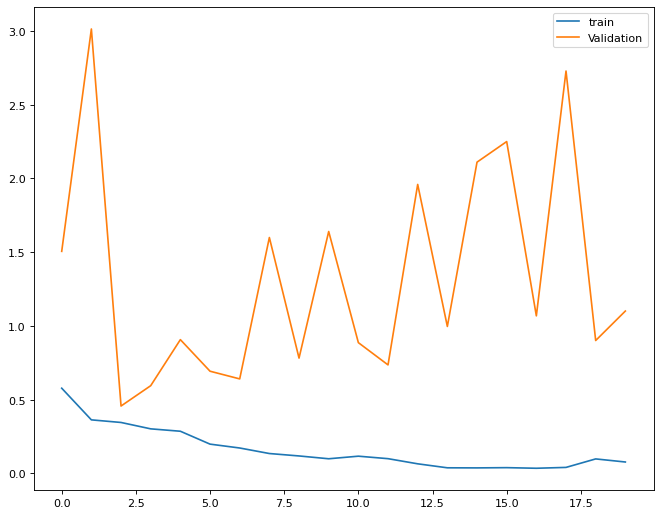

In [ ]:
# Plotting Loss
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()